In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data_csv = pd.read_csv('./data.csv', usecols=[1])

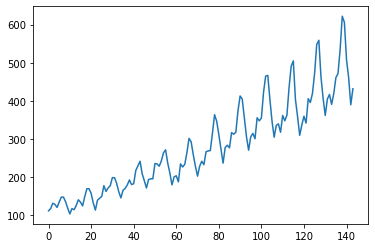

In [3]:
plt.plot(data_csv)

In [4]:
# 数据预处理
data_csv = data_csv.dropna()
dataset = data_csv.values
dataset = dataset.astype('float32')
max_value = np.max(dataset)
min_value = np.min(dataset)
scalar = max_value - min_value
dataset = list(map(lambda x: (x - min_value) / scalar, dataset))

In [5]:
def create_dataset(dataset, look_back=2):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return np.array(dataX), np.array(dataY)

In [6]:
# 创建好输入输出
data_X, data_Y = create_dataset(dataset)

In [7]:
# 划分训练集和测试集，70% 作为训练集
train_size = int(len(data_X) * 0.7)
test_size = len(data_X) - train_size
train_X = data_X[:train_size]
train_Y = data_Y[:train_size]
test_X = data_X[train_size:]
test_Y = data_Y[train_size:]

In [8]:
import torch

train_X = train_X.reshape(-1, 1, 2)
train_Y = train_Y.reshape(-1, 1, 1)
test_X = test_X.reshape(-1, 1, 2)

train_x = torch.from_numpy(train_X)
train_y = torch.from_numpy(train_Y)
test_x = torch.from_numpy(test_X)

In [9]:
from torch import nn

In [10]:
# 定义模型
class lstm_reg(nn.Module):
    def __init__(self, input_size, hidden_size, output_size=1, num_layers=2):
        super(lstm_reg, self).__init__()
        
        self.rnn = nn.LSTM(input_size, hidden_size, num_layers) # rnn
        self.reg = nn.Linear(hidden_size, output_size) # 回归
        
    def forward(self, x):
        x, _ = self.rnn(x) # (seq, batch, hidden)
        s, b, h = x.shape
        x = x.view(s*b, h) # 转换成线性层的输入格式
        x = self.reg(x)
        x = x.view(s, b, -1)
        return x

In [11]:
net = lstm_reg(2, 4)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=1e-2)

In [14]:
print(net)

lstm_reg(
  (rnn): LSTM(2, 4, num_layers=2)
  (reg): Linear(in_features=4, out_features=1, bias=True)
)


In [16]:
# 开始训练
for e in range(1000):
    var_x = train_x
    var_y = train_y
    # 前向传播
    out = net(var_x)
    loss = criterion(out, var_y)
    # 反向传播
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    if (e + 1) % 100 == 0: # 每 100 次输出结果
        print('Epoch: {}, Loss: {:.5f}'.format(e + 1, loss.item()))

Epoch: 100, Loss: 0.00417
Epoch: 200, Loss: 0.00384
Epoch: 300, Loss: 0.00352
Epoch: 400, Loss: 0.00309
Epoch: 500, Loss: 0.00254
Epoch: 600, Loss: 0.00175
Epoch: 700, Loss: 0.00144
Epoch: 800, Loss: 0.00136
Epoch: 900, Loss: 0.00121
Epoch: 1000, Loss: 0.00113


In [17]:
net = net.eval() # 转换成测试模式

In [20]:
data_X = data_X.reshape(-1, 1, 2)
# data_X = torch.from_numpy(data_X)
var_data = data_X
pred_test = net(var_data) # 测试集的预测结果

In [22]:
# 改变输出的格式
pred_test = pred_test.view(-1).detach().numpy()

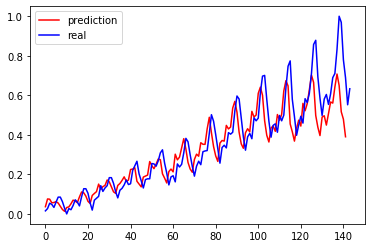

In [23]:
# 画出实际结果和预测的结果
plt.plot(pred_test, 'r', label='prediction')
plt.plot(dataset, 'b', label='real')
plt.legend(loc='best')